In [252]:
from environment import Environment
from agent import Agent, Transition
from trainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

In [253]:
import json
from easydict import EasyDict
from datetime import date
import os
import torch

# Environment Params

In [254]:
args = EasyDict()
args.ENV_NAME = 'Salesman' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #
args.continuous=False

In [255]:
env = Environment.salesman(total_steps=60)

In [256]:
env.context

[1, 1, 1, 1, 1, 1]

In [257]:
state, reward, done, _ = env.step(0)
state, reward, done, _

(1, -2.0, False, None)

In [258]:
state, reward, done, _ = env.step(3)
state, reward, done, _

(4, -3.0, False, None)

# Trainer Params

In [712]:
args.monte_carlo=True
args.augmentation = False
args.final = True 

ALPHA_REF = 0.01 # le alpha qui sert à apprendre Q_ref (PREC inclus)
BETA_REF = 5 # amplification du reward

args.PREC = 0.1 / BETA_REF  # poids relatif des 2 termes dans la mise à jour explo/exploit
args.Q_VAR_MULT = 1

args.ALPHA = ALPHA_REF / args.Q_VAR_MULT / args.PREC  # la division par PREC assure la même "vitesse d'app"
                                                      # quelle que soit la valeur de PREC


args.OBS_LEAK = args.ALPHA / env.N_obs #1e-3  #3e-3 
# OBS_LEAK regule la valeur de KL (si faible : atténue les pics pour les etats 'nouveaux', favorise le 'turn over')




In [713]:
args.ALPHA, args.PREC, args.OBS_LEAK

0.5

# Agent Params

In [716]:
args.isTime = True
args.offPolicy = False
args.BETA = BETA_REF 

args.GAMMA = 1
args.do_reward = None
args.HIST_HORIZON = 200 * int(1/args.OBS_LEAK)

args.act_renorm = False
args.retain_present = False
args.retain_trajectory = False

args.KL_centering = True
args.rtg_centering = True

# Data path

In [717]:
data_path = "data/{}/{}-{}".format(args.ENV_NAME,str(date.today()),args.ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'

data_path += '-LEAK-{}'.format(args.OBS_LEAK)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
data_path += '-ALPHA-{}'.format(ALPHA_REF)

if args.continuous:
    data_path += '-{}'.format(args.optim)
    if args.KNN_prob:
        data_path += '-KNN'    
    data_path += '-PART-{}'.format(args.N_PART)
    data_path += '-HIDDEN-{}'.format(args.N_HIDDEN)
    
    if args.retain_present:
        data_path += '-retain-pres'
    if args.retain_present:
        data_path += '-retain-traj'
    if args.KL_correction:
        data_path += '-KL-corr'
    if args.clip_gradients:
        data_path += '-clip-grad'

In [718]:
data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'
if args.continuous:
    data_path_Q_var = data_path+'-Q_var.pt'
    data_path_Q_ref = data_path+'-Q_ref.pt'
    data_path_Q_KL = data_path+'-Q_KL.pt'

In [719]:
if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [720]:
data_path_npy

'data/Salesman/2021-04-20-Salesman-final-no-reward-LEAK-0.07142857142857142-GAMMA-1-BETA-5-PREC-0.02-ALPHA-0.01.npy'

In [721]:
N = 3000 # Number of episodes

In [722]:
args.do_reward = True

In [723]:
mem_Q_var = []
mem_Q_ref = []
BETA= args.BETA
agent = Agent(env,
              ALPHA=args.ALPHA,
              GAMMA=args.GAMMA, # Episodic agent!
              BETA=BETA, 
              PREC=args.PREC,
              do_reward=args.do_reward,
              isTime=args.isTime,    #!! TimeAgent
              offPolicy=False) 

In [724]:
trainer = Final_variational_trainer(agent, 
                                    monte_carlo=args.monte_carlo, 
                                    final= args.final,
                                    augmentation=args.augmentation,
                                    OBS_LEAK=args.OBS_LEAK,
                                    ref_prob='unif',
                                    KL_centering=args.KL_centering,
                                    rtg_centering=args.rtg_centering) #[2,5] # 

In [725]:
for i in range(N):

    trainer.run_episode()
    mem_Q_var.append(np.array(agent.Q_var_tab))
    mem_Q_ref.append(np.array(agent.Q_ref_tab))     

    if i%100 == 0:
        print(i)
        print("Trajectory: ", trainer.trajectory)
        print("Total reward got: %.4f" % trainer.total_reward)
        obs = env.state
        print(np.mean(trainer.obs_score), trainer.obs_score[obs])




/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
Trajectory:  [0, 3, 1, 3, 3, 1, 3, 1, 6, 1, 5, 6, 2, 5, 5, 5, 1, 5, 5, 3, 5, 1, 1, 5, 2, 4]
Total reward got: -57.2487
1.6863733845095605 1.0
100
Trajectory:  [0, 6, 4, 1, 2, 3, 3, 5]
Total reward got: -15.4641
2.000000000000001 2.019786053886139
200
Trajectory:  [0, 1, 2, 1, 1, 3, 4, 5, 4, 2, 6]
Total reward got: -21.1962
2.000000000000001 2.76628426838049
300
Trajectory:  [0, 6, 3, 1, 6, 3, 3, 5, 4, 2]
Total reward got: -21.1962
2.000000000000001 2.384836123229634
400
Trajectory:  [0, 4, 6, 1, 2, 3, 1, 5]
Total reward got: -16.1962
2.000000000000001 2.0248676265498373
500
Trajectory:  [0, 5, 6, 6, 2, 3, 1, 5, 4]
Total reward got: -17.1962
2.000000000000001 2.8342635527318896
600
Trajectory:  [0, 6, 3, 3, 3, 6, 1, 5, 4, 2]
Total reward got: -19.4641
2.000000000000001 1.9934592679742282
700
Trajectory:  [0, 6, 4, 1, 3, 2, 1, 5]
Total reward got: -17.1962
2.000000000000001 3.1320731459843945
800
Trajectory:  [0, 6, 6, 4, 3, 1, 1, 5, 4, 2]
Total reward got: -18.9282
2.000000000000001 2

In [726]:
trainer.run_episode()
print("Trajectory: ", trainer.trajectory)
print("Total reward got: %.4f" % trainer.total_reward)


Trajectory:  [0, 6, 5, 4, 3, 2, 1]
Total reward got: -12.0000


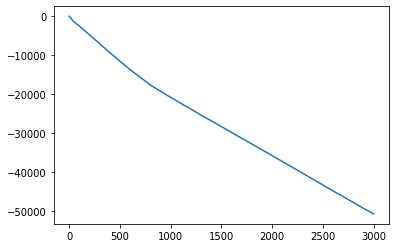

In [727]:
plt.plot(np.cumsum(trainer.mem_total_reward))

(0.0, 3000.0)

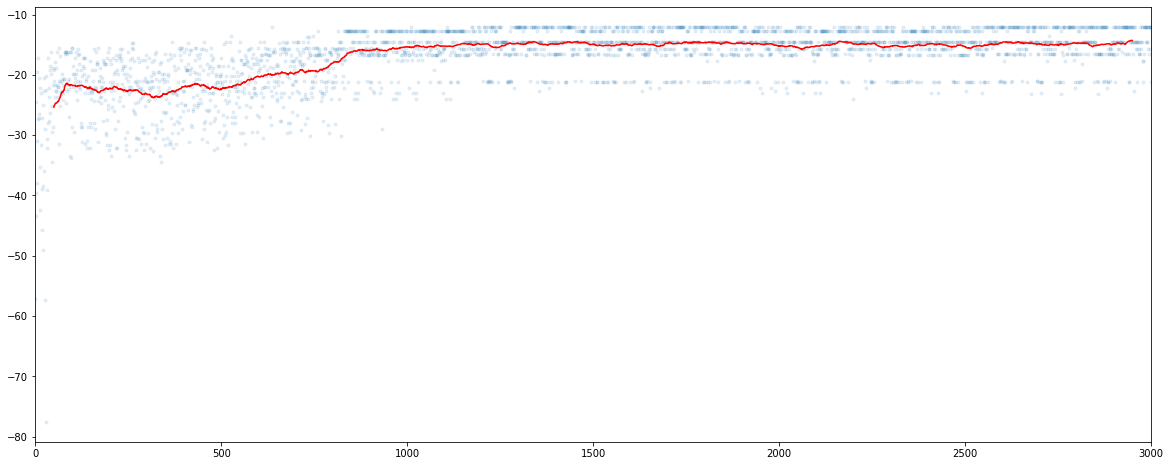

In [728]:
plt.figure(figsize=(20,8))
plt.plot(trainer.mem_total_reward,'.',alpha=.1)
plt.plot(range(50, N-50), np.convolve(trainer.mem_total_reward, np.ones(100)/100)[100:-100], 'r')
plt.xlim(0,N)

(0.0, 3000.0)

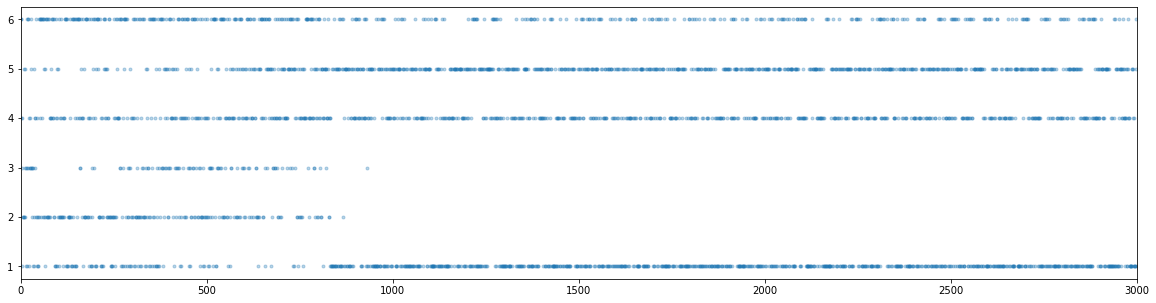

In [729]:
plt.figure(figsize=(20,5)); ax=plt.subplot(111)
ax.plot(trainer.mem_obs_final, '.', alpha=.3)
ax.set_xlim(0,N)

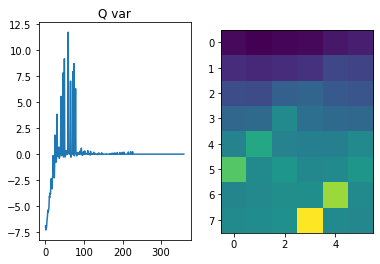

In [730]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab[:8,:])

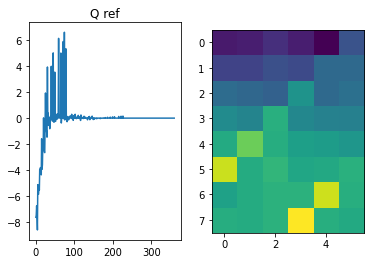

In [731]:
plt.subplot(1,2,1)
plt.plot(agent.Q_ref_tab.flatten())
plt.title('Q ref')
plt.subplot(1,2,2)
plt.imshow(agent.Q_ref_tab[:8,:])

In [732]:
mem_obs_score = np.zeros((env.N_obs, trainer.nb_trials))
mem_p_eff = np.zeros((env.N_obs, trainer.nb_trials))
mem_KL = np.zeros(trainer.nb_trials)
mem_obs_score[trainer.mem_obs_final[0],0] = 1
for t in range(1,trainer.nb_trials):
    obs = trainer.mem_obs_final[t]
    mem_obs_score[:,t] = mem_obs_score[:,t-1] * (1 - args.OBS_LEAK)
    mem_obs_score[obs,t] += 1
    mem_p_eff[:,t] = mem_obs_score[:,t] / np.sum(mem_obs_score[:,t])
    mem_KL[t] = np.log(mem_p_eff[obs,t]) - np.log(trainer.ref_probs[obs])


(0.0, 3001.0)

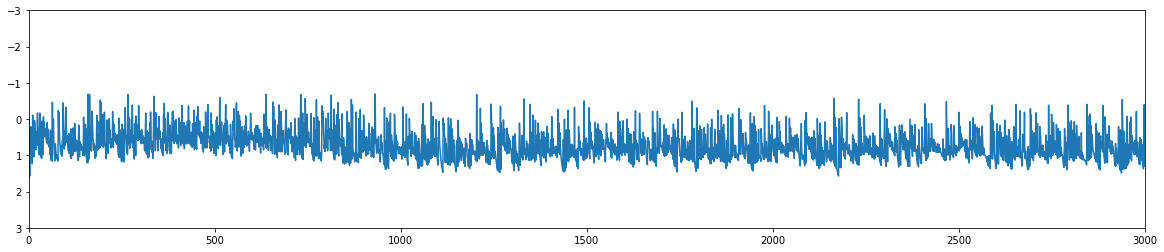

In [733]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_KL)
ax.set_ylim(3,-3)
ax.set_xlim(0,trainer.nb_trials)

(0.0, 1000.0)

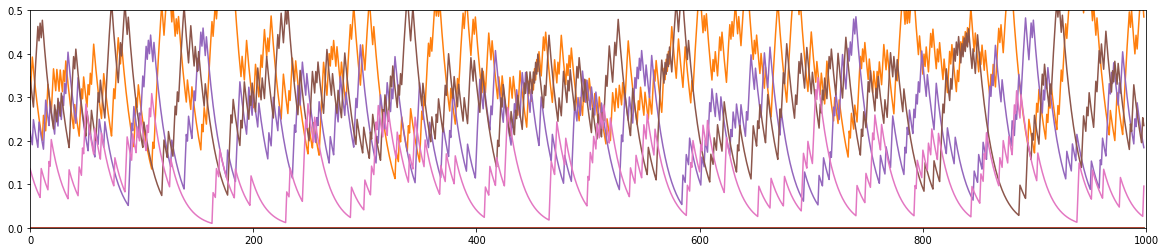

In [740]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_p_eff[:,2001:3000].T)
ax.set_ylim(0,.5)
ax.set_xlim(0,1000)

In [735]:
mem_p_eff.shape

(7, 3001)

Text(0.5, 1.0, 'Q_var')

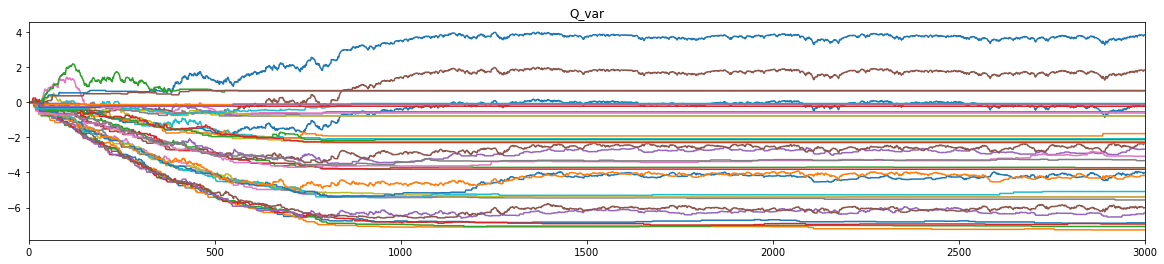

In [736]:
mem_Q_var_arr = np.array(mem_Q_var)
mem_Q_var_flat = mem_Q_var_arr[:,:6,:].reshape((N, -1))
plt.figure(figsize=(20,4)); ax=plt.subplot(111)
ax.plot(mem_Q_var_flat)
ax.set_xlim(0,trainer.nb_trials)
ax.set_title('Q_var')

Text(0.5, 1.0, 'Q_ref')

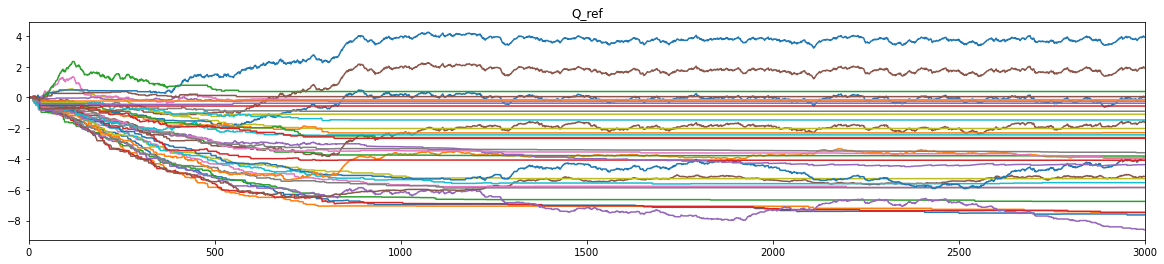

In [737]:
mem_Q_ref_arr = np.array(mem_Q_ref)
mem_Q_ref_flat = mem_Q_ref_arr[:,:6,:].reshape((N, -1))
plt.figure(figsize=(20,4)); ax=plt.subplot(111)
ax.plot(mem_Q_ref_flat)
ax.set_xlim(0,trainer.nb_trials)
ax.set_title('Q_ref')

In [738]:
mem_Q_var_arr.shape

(3000, 60, 6)

In [739]:
agent.mean_KL_final

AttributeError: 'Agent' object has no attribute 'mean_KL_final'

In [ ]:
trainer.OBS_LEAK

In [ ]:
np.mean(trainer.mem_KL_final)